In [1]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline


plt.style.use("/mnt/home/nico/matplotlib.mplstyle")
import h5py
import nba
import sys

sys.path.append("/mnt/home/ecunningham/python")
import gizmo_analysis as ga
import halo_analysis as halo
import utilities as ut

### read in the snapshot

In [70]:
sim_directory = "/mnt/ceph/users/firesims/fire2/metaldiff/{}_res7100/".format('m12b')

part=ga.io.Read.read_snapshots(['dark'],snapshot_values=380,
                               simulation_directory=sim_directory, 
                               assign_hosts=True, assign_orbits=True)


# in utilities.simulation.Snapshot():
* reading:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/snapshot_times.txt

  using snapshot index = 380, redshift = 0.506


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/output/snapdir_380/snapshot_380.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 74537000 particles
    dark2     (id = 2): 6750970 particles
    gas       (id = 0): 64275517 particles
    star      (id = 4): 10744634 particles
    blackhole (id = 5): 0 particles

* reading species: ['dark']
* reading particles from:
    snapshot_380.0.hdf5
    snapshot_380.1.hdf5
    snapshot_380.2.hdf5
    snapshot_380.3.hdf5
    snapshot_380.4.hdf5
    snapshot_380.5.hdf5
    snapshot_380.6.hdf5
    snapshot_380.7.hdf5

* reading cosmological parameters from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/initial_condition/ic_agora_m12b.conf

* checking sanity of particle pr

### Compute distances / velocities relative to the main halo

In [120]:
part['star'].keys()

dict_keys(['position', 'mass', 'massfraction', 'id.child', 'id.generation', 'id', 'potential', 'form.scalefactor', 'velocity', 'host.distance', 'host.distance.total', 'host.distance.norm', 'host.velocity', 'host.velocity.total', 'host.velocity.tan', 'host.velocity.rad', 'host.velocity.ratio', 'host.velocity.norm'])

In [121]:
ga.io.Read.assign_host_orbits(part)

AttributeError: 'ReadClass' object has no attribute 'assign_host_orbits'

### Read in the halo catalog for the same snapshot

In [72]:
hal = halo.io.IO.read_catalogs(simulation_directory="/mnt/ceph/users/ecunningham/latte/m12b_res7100/",
                               snapshot_value_kind='index', 
                               rockstar_directory='halo/rockstar_dm/',
                               snapshot_values=336)


# in utilities.simulation.Snapshot():
* reading:  mnt/ceph/users/ecunningham/latte/m12b_res7100/snapshot_times.txt

  using snapshot index = 336, redshift = 0.684

* read 51340 halos from:  mnt/ceph/users/ecunningham/latte/m12b_res7100/halo/rockstar_dm/catalog_hdf5/halo_336.hdf5

# in halo_analysis.halo_io.Particle():
! cannot find halo file:  mnt/ceph/users/ecunningham/latte/m12b_res7100/halo/rockstar_dm/catalog_hdf5/star_336
* assigning primary host and coordinates wrt it to halo catalog...  finished



#### the halo catalog is the result of running a "halo finder" (in this case Rockstar) on the dark matter in the simulation (not the stars). Then another program is used to find the star particles with similar positions and velocities to each DM halo.

#### The halo finder also calculates a bunch of properties for each halo, as listed here: 

In [73]:
list(hal.keys())

['axis.b/a',
 'axis.c/a',
 'descendant.id',
 'host.distance',
 'host.index',
 'host.velocity',
 'host.velocity.rad',
 'host.velocity.tan',
 'id',
 'id.to.index',
 'mass',
 'mass.180m',
 'mass.200c',
 'mass.200m',
 'mass.500c',
 'mass.bound',
 'mass.lowres',
 'mass.vir',
 'position',
 'position.offset',
 'radius',
 'scale.radius',
 'scale.radius.klypin',
 'spin.bullock',
 'spin.peebles',
 'vel.circ.max',
 'vel.std',
 'velocity',
 'velocity.offset']

One property in this list is `star.indices` - that is the list of indices for star particles belonging to a particular halo.

We have to start, however, by finding all the halos that are within the region we want to study, and excluding the main halo. The main halo is the most massive one in the box:

In [4]:
index_main_halo = np.where(hal['mass']==np.max(hal['mass']))[0]
print(index_main_halo,hal['mass'][index_main_halo])

[18085] [1.0405556e+12]


We can find the distance of each halo from the main one. Most are within the virial radius but there are plenty further out

Text(0, 0.5, 'number of halos')

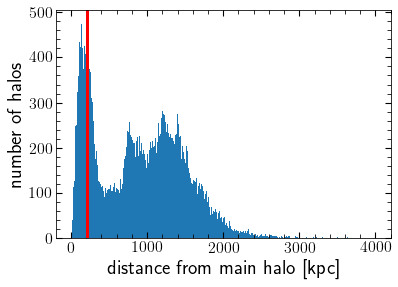

In [5]:
halo_dist = np.sqrt((hal['host.distance']**2).sum(axis=1))

plt.hist(halo_dist, bins=np.linspace(0,4000,500));

plt.axvline(hal['radius'][index_main_halo],color='red')  #put a line at the virial radius of the main halo

plt.xlabel('distance from main halo [kpc]')
plt.ylabel('number of halos')

However only a few within the virial radius of the main halo (called "subhalos") have any stars in them

In [144]:
print("Total number of subhalos:",len(hal['id'][halo_dist<hal['radius'][index_main_halo]]))
print("Number of subhalos with stars in them:",len(hal['id'][(halo_dist<hal['radius'][index_main_halo])&(hal['star.mass']>0)]))

Total number of subhalos: 7938
Number of subhalos with stars in them: 31


This is because they are mostly very low mass - remember one DM particle is ~40,000 solar masses. The halo finder thinks any structure with more than 30 particles is a halo. The halo to the extreme right in the following plot is the main halo

In [6]:
hal['star.mass']

array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)

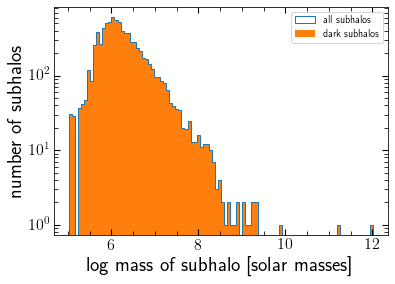

In [7]:
plt.hist(np.log10(hal['mass'][halo_dist<hal['radius'][index_main_halo]]),
        bins=100,histtype='step',log=True,label='all subhalos');
#plt.hist(np.log10(hal['mass'][(halo_dist<hal['radius'][index_main_halo])&(hal['star.mass']>0)]),
#        bins=100,log=True,label='subhalos with stars');

plt.hist(np.log10(hal['mass'][(halo_dist<hal['radius'][index_main_halo])]),
        bins=100,log=True,label='dark subhalos');

plt.xlabel('log mass of subhalo [solar masses]')
plt.ylabel('number of subhalos')
plt.legend()

We actually want to select all the halos with stars (other than the main one) since we are plotting the profiles beyond the virial radius.

In [8]:
halos_with_stars_not_main = np.where((hal['mass']>0))
halos_with_stars_not_main = np.setdiff1d(halos_with_stars_not_main, index_main_halo)  #removes the main halo

In [9]:
len(halos_with_stars_not_main)

46788

Now we can build a list of all the star particle indices that belong to one of the other halos:

In [67]:
hal['dark2.mass']

dict_keys(['accrete.rate', 'accrete.rate.100Myr', 'accrete.rate.tdyn', 'am.phantom', 'am.progenitor.main', 'axis.b/a', 'axis.c/a', 'descendant.snapshot', 'host.distance', 'host.index', 'host.velocity', 'host.velocity.rad', 'host.velocity.tan', 'id', 'id.to.index', 'infall.first.mass', 'infall.first.snapshot', 'infall.first.vel.circ.max', 'infall.mass', 'infall.snapshot', 'infall.vel.circ.max', 'major.merger.snapshot', 'mass', 'mass.180m', 'mass.200c', 'mass.200m', 'mass.500c', 'mass.bound', 'mass.half.snapshot', 'mass.lowres', 'mass.peak', 'mass.peak.snapshot', 'mass.vir', 'position', 'position.offset', 'progenitor.number', 'radius', 'scale.radius', 'scale.radius.klypin', 'spin.bullock', 'spin.peebles', 'tree.index', 'vel.circ.max', 'vel.circ.peak', 'vel.std', 'velocity', 'velocity.offset', 'dark2.mass', 'star.form.time.100', 'star.form.time.50', 'star.form.time.90', 'star.form.time.95', 'star.form.time.dif.68', 'star.indices', 'star.mass', 'star.massfraction', 'star.number', 'star.pos

In [54]:
hal['id.to.index']

array([    0,     1,     2, ..., 29074, 29075, 29076], dtype=int32)

In [35]:
hal['mass'][halos_with_stars_not_main]

array([5910399.  , 1512820.5 , 1125797.8 , ..., 2216381.8 , 4045869.  ,
        879529.94], dtype=float32)

In [31]:
np.hstack(hal['mass'][halos_with_stars_not_main])

array([5910399.  , 1512820.5 , 1125797.8 , ..., 2216381.8 , 4045869.  ,
        879529.94], dtype=float32)

In [37]:
hal['id']

array([    0,     1,     2, ..., 42664, 42665, 42666], dtype=int32)

In [26]:
stars_in_halos = np.unique(np.hstack(hal[''][halos_with_stars_not_main]))

In [24]:
len(part['dark']['mass'])

74537000

In [28]:
print(len(stars_in_halos))

4518


How much stellar mass is this compared to the total in the simulation?

In [133]:
print(np.sum(part['star']['mass'][stars_in_halos])/np.sum(part['star']['mass']))

0.11927967


Plot the positions of the stars in halos to see if we did it right

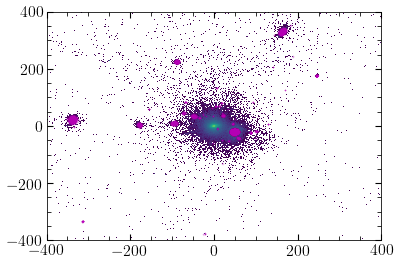

In [134]:
plt.hist2d(part['star']['host.distance'][:,0],part['star']['host.distance'][:,1],
          bins=[np.linspace(-400,400,800),np.linspace(-400,400,800)],
            norm=LogNorm());
plt.plot(part['star']['host.distance'][stars_in_halos,0],part['star']['host.distance'][stars_in_halos,1],'.m',ms=1,alpha=0.1)

Everything else in the simulation is by definition *not* in a subhalo:

In [160]:
np.setdiff1d?

In [135]:
not_in_subs=np.setdiff1d(range(len(part['star']['mass'])),stars_in_halos);

We can see the effect of removing the bound stars by plotting a rough version of the density profile

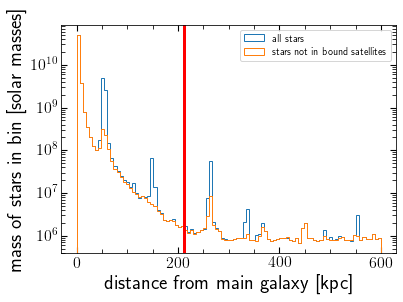

In [136]:
plt.hist(part['star']['host.distance.total'][:],
        weights=part['star']['mass'][:],
        log=True,
        bins=np.linspace(0,600,100),
        histtype='step',
        label='all stars');

plt.hist(part['star']['host.distance.total'][not_in_subs],
        weights=part['star']['mass'][not_in_subs],
        log=True,
        bins=np.linspace(0,600,100),
        histtype='step',
        label='stars not in bound satellites');

plt.axvline(hal['radius'][index_main_halo],color='red')

plt.xlabel('distance from main galaxy [kpc]')
plt.ylabel('mass of stars in bin [solar masses]')
plt.legend()

Finally we can plot the distribution of stars with and without removing the bound ones. You can see the strategy isn't always perfect (compare the blob at roughly (-200,-150) kpc in the two panels) but at least doesn't leave "holes"

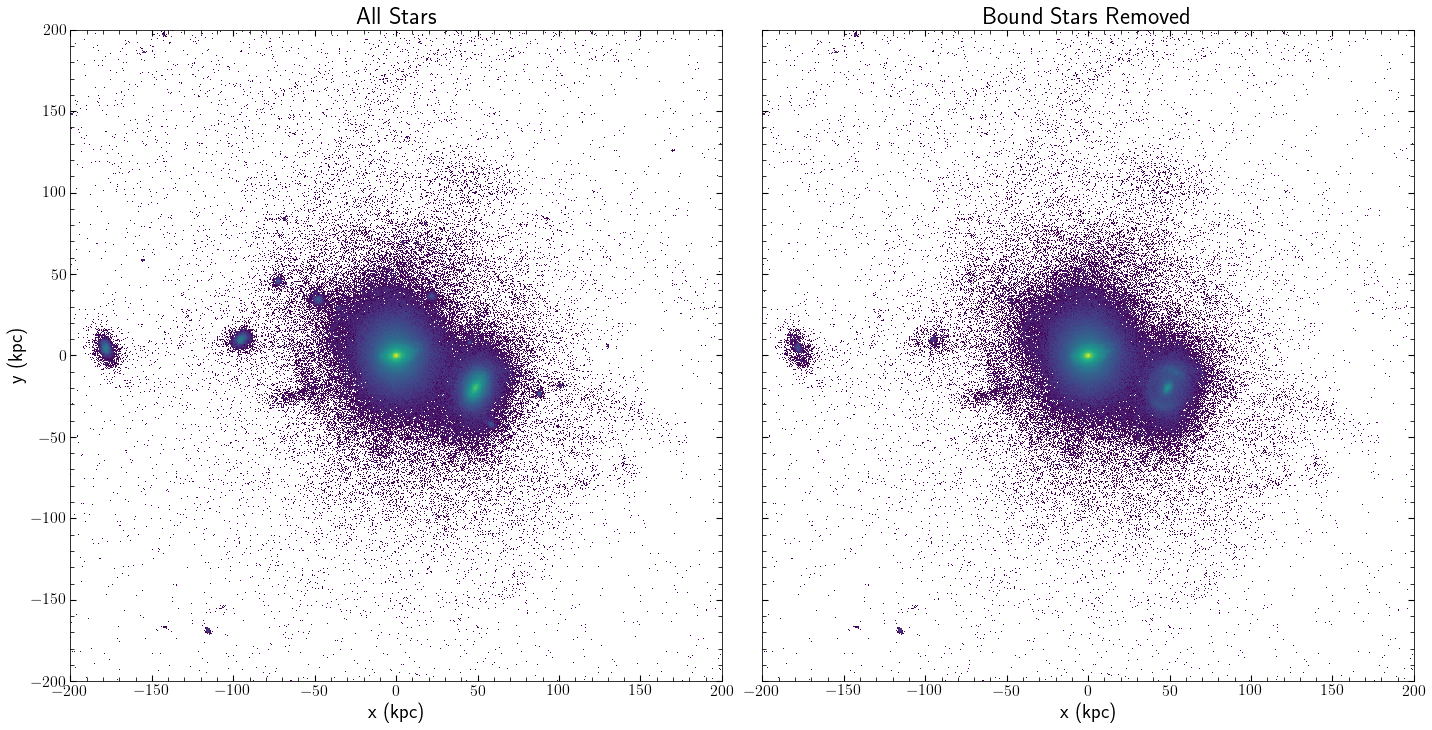

In [137]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10),sharey=True)

ax[0].hist2d(part['star']['host.distance'][:,0],part['star']['host.distance'][:,1],
          bins=np.linspace(-200,200,800),
            norm=LogNorm());
ax[0].set_title('All Stars')
#ax[0].text(380,-380,'All stars',bbox=dict(facecolor='white', alpha=0.8),ha='right',va='bottom')

ax[1].hist2d(part['star']['host.distance'][not_in_subs,0],part['star']['host.distance'][not_in_subs,1],
          bins=np.linspace(-200,200,800),
            norm=LogNorm());
ax[1].set_title('Bound Stars Removed')
#ax[1].text(380,-380,'Stars not in bound satellites',bbox=dict(facecolor='white', alpha=0.8),ha='right',va='bottom')


for a in ax:
    a.set_aspect('equal')
    a.set_xlabel('x (kpc)')
    
ax[0].set_ylabel('y (kpc)')

fig.tight_layout()

#fig.savefig('m12b_385_bound_stars_removal.png',dpi=800)

We can save the indices of the stars to a file so we don't have to do this more than once per galaxy (per snapshot)

In [138]:
np.savetxt('m12b_385_unbound_star_indices.txt',not_in_subs,fmt='%d')

Then you can just

In [78]:
not_in_subs=np.loadtxt('m12i_unbound_star_indices.txt')

to get the list of star particle indices

In [33]:
sub_mask=np.zeros(len(part['star']['host.distance']), dtype='bool')
sub_mask[not_in_subs.astype(int)]=True

In [46]:
halo.io.Particle.assign_particle_indices(hal, part, 'star', 
                        lowres_mass_frac_max=1e-6, #contamination from low-resolution particles (shouldn't matter when restricting host distance)
                        mass_limits=[1e8, 8e11], #mass range of subhalos to consider
                        vel_circ_max_limits=[1,np.Inf], #not used (use halo_velocity_frac_max instead)
                        halo_radius_frac_max=1, #keep particles up to virial radius
                        radius_max=100, #distance from host (taken care of by halo indices)
                        halo_velocity_frac_max=2.0, #keep particles with velocity up to 2vc (i.e. escape velocity)
                        particle_number_fraction_converge=np.Inf, #turned off
#                        hal_indices=subs_cat #indices of specific halos to assign particles
                        )

* assigning star particle indices to 439 halos within property limits
 [                                                                      ] (00.0%                                                                      ] (00.0%                                                                      ] (00.2%                                                                      ] (00.5%                                                                      ] (00.7%=                                                                     ] (00.9%=                                                                     ] (01.1%=                                                                     ] (01.4%=                                                                     ] (01.6%=                                                                     ] (01.8%=                                                                     ] (02.1%==                                                                    

In [47]:
stars_in_halos = np.unique(np.hstack(hal['star.indices'][halos_with_stars_not_main]))

In [48]:
not_in_subs=np.setdiff1d(range(len(part['star']['mass'])),stars_in_halos);

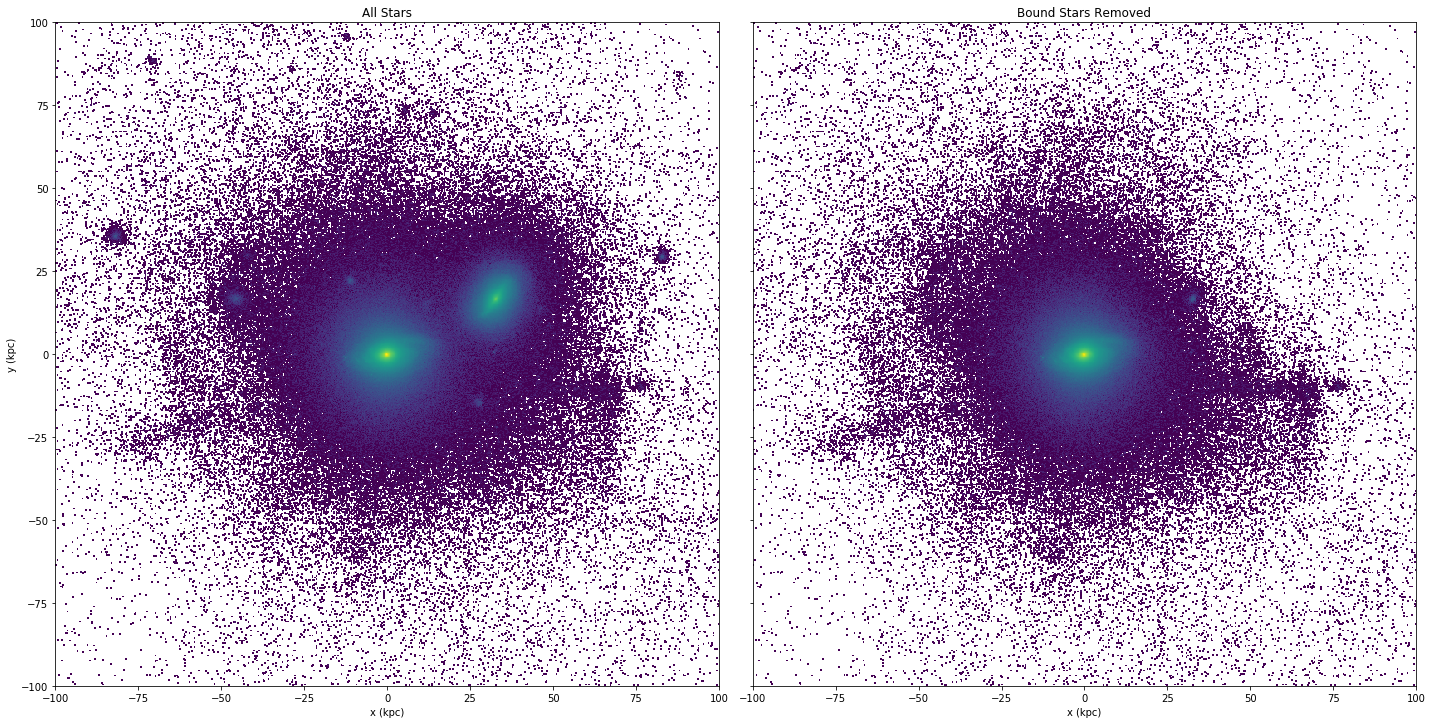

In [49]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10),sharey=True)

ax[0].hist2d(part['star']['host.distance'][:,0],part['star']['host.distance'][:,1],
          bins=np.linspace(-100,100,800),
            norm=LogNorm());
ax[0].set_title('All Stars')
#ax[0].text(380,-380,'All stars',bbox=dict(facecolor='white', alpha=0.8),ha='right',va='bottom')

ax[1].hist2d(part['star']['host.distance'][not_in_subs,0],part['star']['host.distance'][not_in_subs,1],
          bins=np.linspace(-100,100,800),
            norm=LogNorm());
ax[1].set_title('Bound Stars Removed')
#ax[1].text(380,-380,'Stars not in bound satellites',bbox=dict(facecolor='white', alpha=0.8),ha='right',va='bottom')


for a in ax:
    a.set_aspect('equal')
    a.set_xlabel('x (kpc)')
    
ax[0].set_ylabel('y (kpc)')

fig.tight_layout()


In [50]:
np.savetxt('m12b_385_unbound_star_indices.txt',not_in_subs,fmt='%d')

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([  0.   ,   0.125,   0.25 ,   0.375,   0.5  ,   0.625,   0.75 ,
          0.875,   1.   ,   1.125,   1.25 ,   1.375,   1.5  ,   1.625,
          1.75 ,   1.875,   2.   ,   2.125,   2.25 ,   2.375,   2.5  ,
          2.625,   2.75 ,   2.875,   3.   ,   3.125,   3.25 ,   3.375,
          3.5  ,   3.625,   3.75 ,   3.875,   4.   ,   4.125,   4.25 ,
          4.375,   4.5  ,   4.625,   4.75 ,   4.875,   5.   ,   5.125,
          5.25 ,   5.375,   5.5  ,   5.625,   5.75 ,   5.875,   6.   ,
          6.125,   6.25 ,   6.375,   6.5  ,   6.625,   6.75 ,   6.875,
          7.   ,   7.125,   7.25 ,   7.375,   7.5  ,   7.625,   7.75 ,
          7.875,   8.   ,   8.125,   8.25 ,   8.375,   8.5  ,   8.625,
          8.75 ,   8.875,   9.   ,   9.12

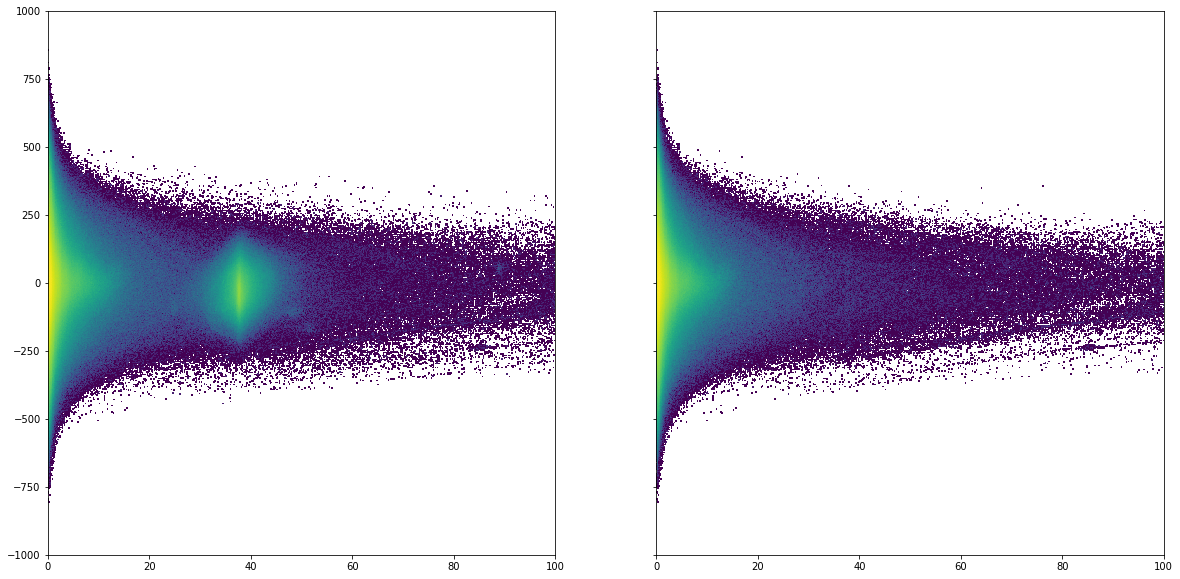

In [72]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10),sharey=True)

ax[0].hist2d(part['star']['host.distance.total'],part['star']['host.velocity.rad'],range=[[0,100], [-1000,1000]], \
             bins=800, norm=LogNorm())
ax[1].hist2d(part['star']['host.distance.total'][not_in_subs],part['star']['host.velocity.rad'][not_in_subs],range=[[0,100], [-1000,1000]], \
             bins=800, norm=LogNorm())
#             bins=np.linspace(-1000,1000,800))#, '.')#,bins=np.linspace(-1000,1000,800),
#            norm=LogNorm());
#ax[0].set_title('All Stars')
#ax[0].text(380,-380,'All stars',bbox=dict(facecolor='white', alpha=0.8),ha='right',va='bottom')

#ax[1].hist2d(part['star']['host.distance.total'][not_in_subs],part['star']['host.velocity.rad'][not_in_subs],
#          bins=np.linspace(-1000,1000,800),
#            norm=LogNorm());
#ax[1].set_title('Bound Stars Removed')
#ax[1].text(380,-380,'Stars not in bound satellites',bbox=dict(facecolor='white', alpha=0.8),ha='right',va='bottom')


#for a in ax:
#    a.set_aspect('equal')
#    a.set_xlabel('x (kpc)')
    
#ax[0].set_ylabel('y (kpc)')

#fig.tight_layout()


#plt.plot(part['star']['host.distance.total'], part['star']['host.velocity.rad'], '.')

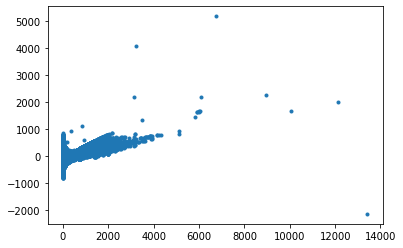

In [58]:
plt.plot(part['star']['host.distance.total'], part['star']['host.velocity.rad'], '.')

In [53]:
for k in part['star'].keys():
    print(k)

position
mass
massfraction
id.child
id.generation
id
potential
form.scalefactor
velocity
host.distance
host.distance.total
host.distance.norm
host.velocity
host.velocity.total
host.velocity.tan
host.velocity.rad
host.velocity.ratio
host.velocity.norm


  histogram min, med, max = 4.164e+03, 1.523e+04, 7.883e+09


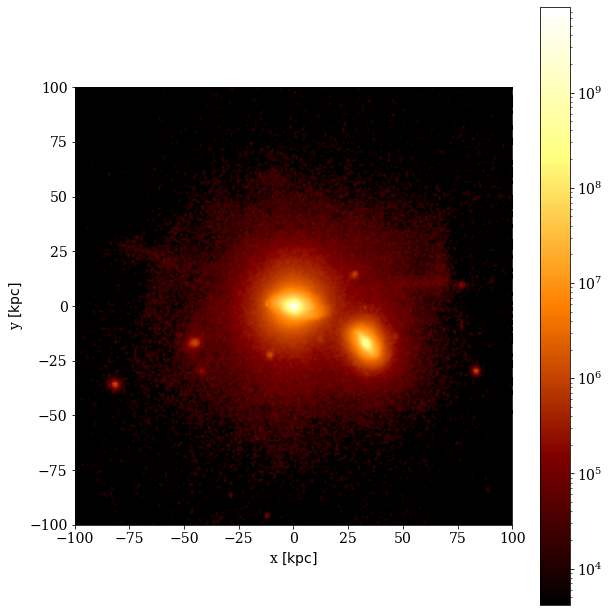

AttributeError: 'NoneType' object has no attribute 'plot'

In [21]:
plt.figure(3, figsize=(10,10))
f=ga.plot.Image.plot_image(part, species_name='star', distances_max=100, background_color='black', \
                         dimensions_plot=[0,1], figure_index=3)

#ax[].plot(previous_orb[:,0], previous_orb[:,1])
f.plot(future_orb[:,0], future_orb[:,1],color='white')

In [7]:
plt.rc('font', **{'family':'Serif', 'size':14})

129


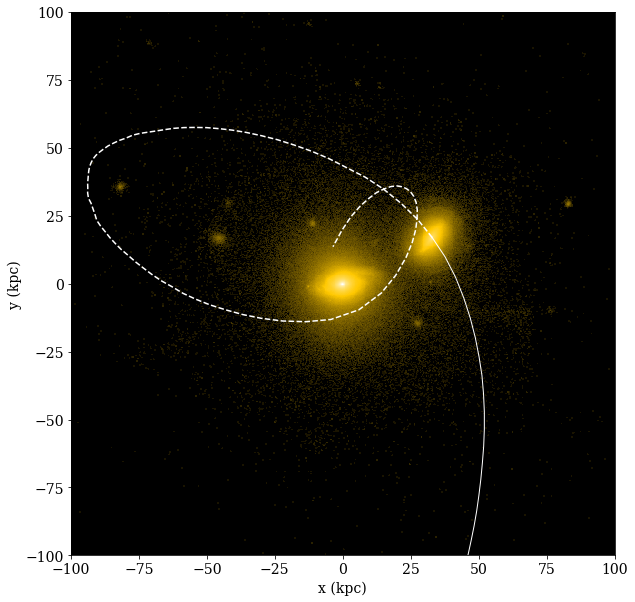

In [23]:
plt.figure(figsize=(10,10))
plt.hist2d(part['star']['host.distance'][:,0],part['star']['host.distance'][:,1],
          bins=np.linspace(-100,100,600),
            norm=LogNorm(), cmap='byw');

plt.gca().set_aspect('equal')
ax=plt.gca()
ax.set_facecolor('black')
plt.plot(previous_orb[:,0], previous_orb[:,1], color='white', linewidth=1)
mask=(future_orb[:,0]==0)&(future_orb[:,1]==0)&(future_orb[:,2]==0)
print(np.sum(mask))
plt.plot(future_orb[:,0][~mask], future_orb[:,1][~mask], color='white', linestyle='--')
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')

#c1=plt.patch.Circle(0, 0, radius=60)
#plt.add_patch()

#plt.rc('font', **{'family':'Serif', 'size':14})
plt.savefig('m12b_385_lmc_orbit.png')

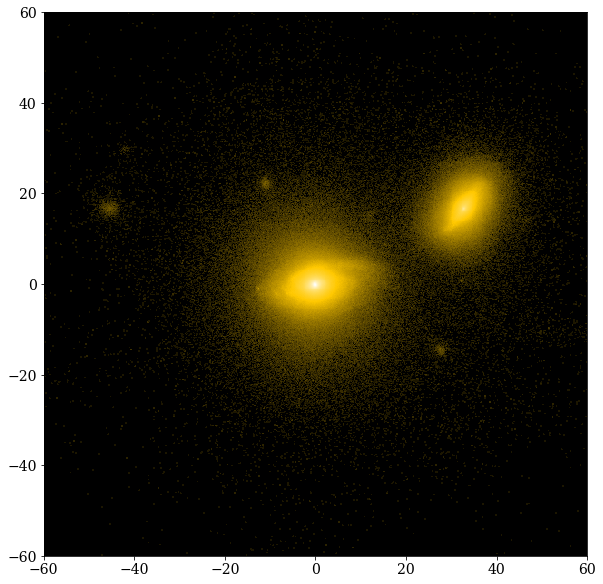

In [16]:
plt.figure(figsize=(10,10))
plt.hist2d(part['star']['host.distance'][:,0],part['star']['host.distance'][:,1],
          bins=np.linspace(-60,60,600),
            norm=LogNorm(), cmap='byw', cmin=1);

plt.gca().set_aspect('equal')
ax=plt.gca()
ax.set_facecolor('black')

In [5]:
future_orb=np.load('m12b_385_lmc_future_orbit.npy')
previous_orb=np.load('m12b_385_lmc_prev_orbit.npy')

In [92]:
print(future_orb)

[[ 32.908375    16.943731     8.137191  ]
 [ 27.550465    23.601152    12.003172  ]
 [ 21.512789    29.488106    15.35196   ]
 [ 14.959911    34.799835    18.459986  ]
 [  8.243468    39.17436     21.192947  ]
 [  1.5112647   42.618195    23.051434  ]
 [ -5.1434116   46.0165      25.027544  ]
 [-11.589042    48.752426    26.54032   ]
 [-17.928259    51.01115     27.82718   ]
 [-24.08772     52.958138    28.881138  ]
 [-29.937002    54.424564    29.859077  ]
 [-35.454887    55.61171     30.693094  ]
 [-40.636208    56.46632     31.60084   ]
 [-45.478455    57.005       32.29598   ]
 [-50.063198    57.390972    32.72549   ]
 [-54.42114     57.462807    33.08053   ]
 [-58.42252     57.406307    33.472256  ]
 [-62.195854    57.12778     33.64698   ]
 [-65.73398     56.62022     33.723625  ]
 [-68.722466    56.150913    33.421726  ]
 [-71.78432     55.692642    33.24733   ]
 [-74.59202     55.267532    33.182014  ]
 [-77.2874      54.616245    33.093975  ]
 [-79.78378     53.518574    32.55

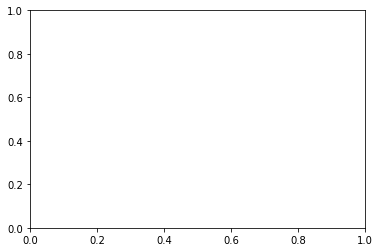